# 1. Set up

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

!pip install tensorflow-addons
import tensorflow_addons as tfa
import pandas as pd
import json
import zipfile
import os
import seaborn as sns
import random
import shutil
import time

from PIL import Image
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.applications import ResNet152V2
from keras.applications.resnet_v2 import preprocess_input
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint, TensorBoard
!pip install wandb
import wandb
#from wandb.keras import WandbCallback

!mkdir output
!mkdir output/tmp-augmented-images/
random.seed(123)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00


# 2. Prepare dataset

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Change the working directory to the desired path
os.chdir('/content/drive/MyDrive/Pneumonia_Detection/Model')

# Verify the current working directory
print('Current working directory:', os.getcwd())

Current working directory: /content/drive/MyDrive/Pneumonia_Detection/Model


# 3. Resampling data

In [ ]:
def resample_data(move_from, move_to, cl, images_to_move=100):
  path = "./" + 'pneumonia_data'

  classes = os.listdir(path + move_from)

  cl += '/'
  curr_path = path + move_from + cl
  for _, _, files in os.walk(curr_path):
    random.shuffle(files)
    files_to_move = files[:images_to_move]
    for fn in files_to_move:
      shutil.move(curr_path + fn, path + move_to + cl + fn)
      #print('Moved ' + curr_path + fn)

  print('Resampled Images')

move_from, move_to = 'train/', 'test/'
#resample_data(move_from, move_to, 'NORMAL', 200)
# Training images
print('Number of COVID training images:')
!ls pneumonia_data/train/COVID-19/ | wc -l
print('Number of NORMAL training images:')
!ls pneumonia_data/train/Normal/ | wc -l
print('Number of PNEUMONIA training images:')
!ls pneumonia_data/train/Pneumonia// | wc -l
print()
# Validation images
print('Number of COVID training images:')
!ls pneumonia_data/val/COVID-19/ | wc -l
print('Number of NORMAL validation images:')
!ls pneumonia_data/val/Normal/ | wc -l
print('Number of PNEUMONIA validation images:')
!ls pneumonia_data/val/Pneumonia/ | wc -l
print()
# Test images
#resample_data('test/', 'val/', 'PNEUMONIA', 2690)
print('Number of COVID training images:')
!ls pneumonia_data/test/COVID_19/ | wc -l
print('Number of NORMAL test images:')
!ls pneumonia_data/test/Normal/ | wc -l
print('Number of PNEUMONIA test images:')
!ls pneumonia_data/test/Pneumonia/ | wc -l

Number of COVID training images:
1100
Number of NORMAL training images:
3026
Number of PNEUMONIA training images:
3875

Number of COVID training images:
171
Number of NORMAL validation images:
235
Number of PNEUMONIA validation images:
765

Number of COVID training images:
10
Number of NORMAL test images:
10
Number of PNEUMONIA test images:
20


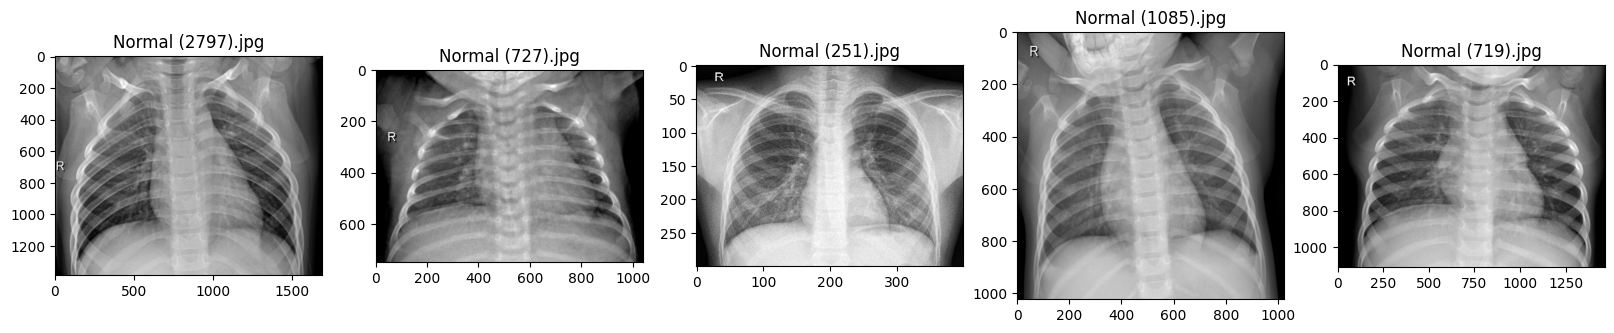

In [ ]:
def viewImagesFromDir(path, num=5):
  #Display num random images from dataset. Rerun cell for new random images. The images are only single-channel

  img_paths_visualise = sorted(
    os.path.join(path, fname)
    for fname in os.listdir(path)
    if fname.endswith(".jpg")
)

  random.shuffle(img_paths_visualise)

  fig, ax = plt.subplots(1, num, figsize=(20, 10))
  for i in range(num):
    ax[i].imshow(Image.open(img_paths_visualise[i]))
    index = img_paths_visualise[i].rfind('/') + 1
    ax[i].title.set_text(img_paths_visualise[i][index:])

  fig.canvas.draw()
  time.sleep(1)

viewImagesFromDir('pneumonia_data/train/Normal/', num=5)

# 4. Assigning variables

In [ ]:
base_dir = 'pneumonia_data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

# Directory with our training covid 19 pictures
train_covid_dir = os.path.join(train_dir, 'COVID-19')
# Directory with our training normal pictures
train_normal_dir = os.path.join(train_dir, 'Normal')
# Directory with our training pneumonia pictures
train_pneumonia_dir = os.path.join(train_dir, 'Pneumonia')
# Directory with our validation covid 19 pictures
validation_covid_dir = os.path.join(validation_dir, 'COVID-19')
# Directory with our validation normal pictures
validation_normal_dir = os.path.join(validation_dir, 'Normal')
# Directory with our validation pneumonia pictures
validation_pneumonia_dir = os.path.join(validation_dir, 'Pneumonia')

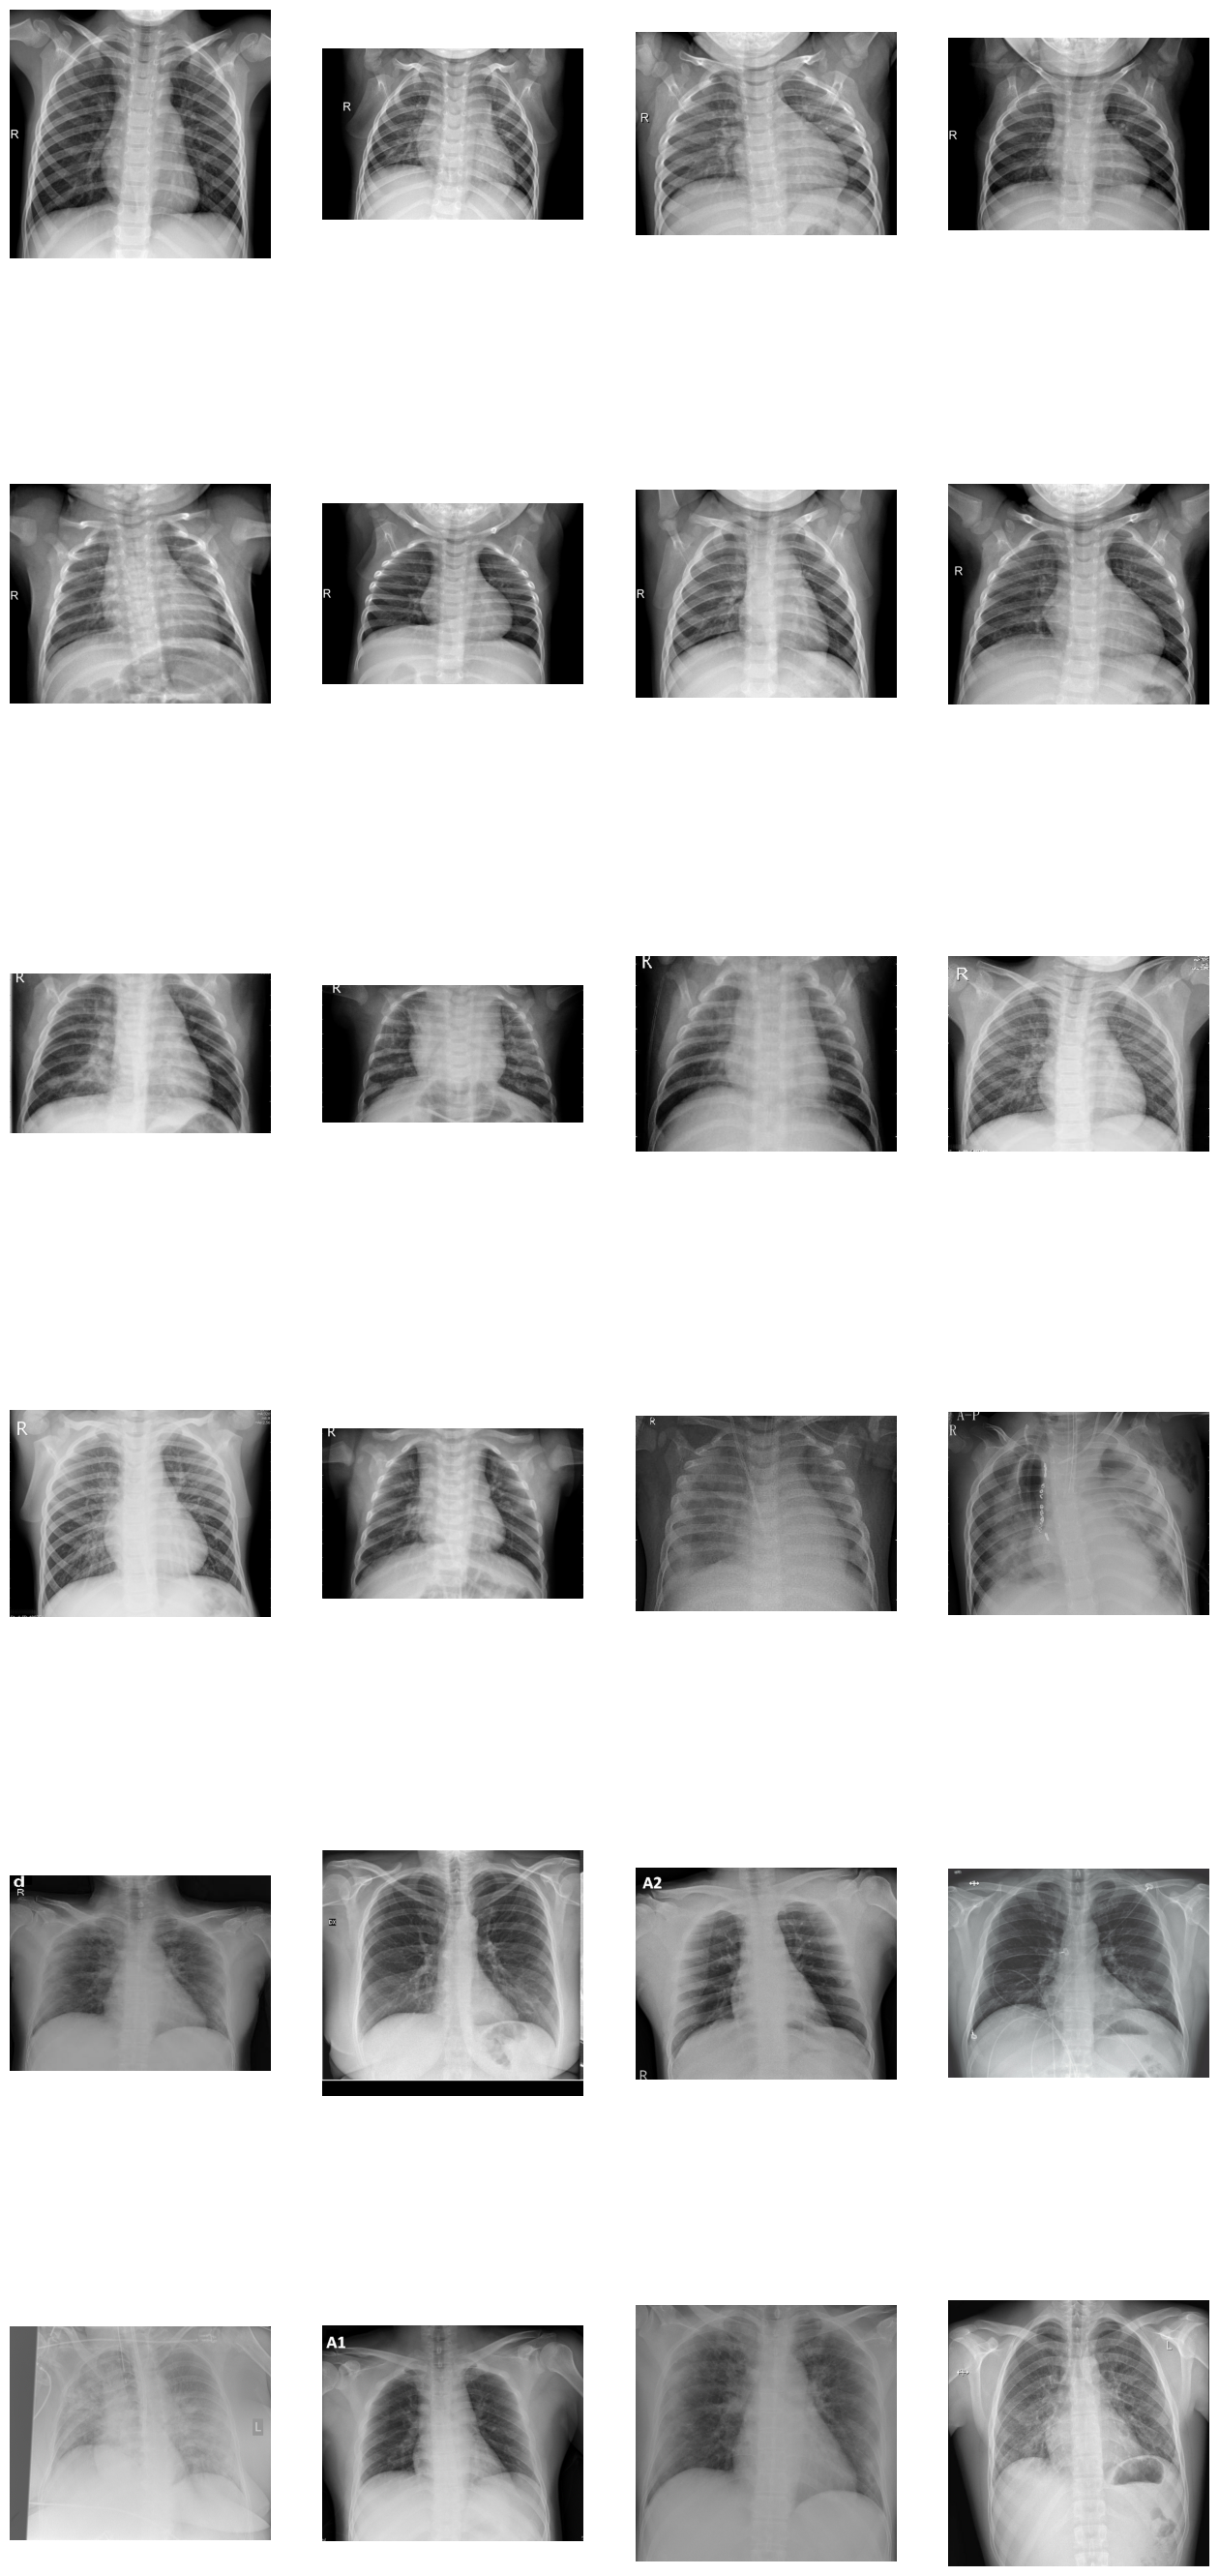

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 6
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*6)
pic_index = 100
train_covid_fnames = os.listdir( train_covid_dir)
train_normal_fnames = os.listdir( train_normal_dir )
train_pneumonia_fnames = os.listdir( train_pneumonia_dir )

next_covid_pix = [os.path.join(train_covid_dir, fname)
for fname in train_covid_fnames[ pic_index-8:pic_index]
]
next_normal_pix = [os.path.join(train_normal_dir, fname)
for fname in train_normal_fnames[ pic_index-8:pic_index]
]
next_pneumonia_pix = [os.path.join(train_pneumonia_dir, fname)
for fname in train_pneumonia_fnames[ pic_index-8:pic_index]
]
for i, img_path in enumerate(next_normal_pix+next_pneumonia_pix+next_covid_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# 5. Setting up generator

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 32, class_mode = 'categorical', target_size = (224, 224))
validation_generator = test_datagen.flow_from_directory(validation_dir, batch_size = 32, class_mode = 'categorical', target_size = (224, 224))

Found 8001 images belonging to 3 classes.
Found 1171 images belonging to 3 classes.


# 6. Training model

In [ ]:
# Load ResNet152V2 model
base_model = ResNet152V2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

234545216/234545216 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Add custom layers on top of the base model
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(3, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

# Use the legacy Keras optimizer
# optimizer_legacy = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001)

# model.compile(optimizer = optimizer_legacy, loss = 'binary_crossentropy', metrics = ['acc'])

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])


In [ ]:
import scipy
print(scipy.__version__)
from keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
  # Decay the learning rate by a factor of 0.1 every 10 epochs
  if epoch % 10 == 0 and epoch != 0:
    lr = lr * 0.1
  return lr

# Define a learning rate scheduler callback
#lr_scheduler_callback = LearningRateScheduler(lr_scheduler)
resnet_history = model.fit(train_generator, validation_data=validation_generator, epochs=20)

1.11.4
Epoch 1/20
251/251 [==============================] - 2194s 9s/step - loss: 0.5736 - acc: 0.8871 - val_loss: 0.2322 - val_acc: 0.9206
Epoch 2/20
251/251 [==============================] - 260s 1s/step - loss: 0.2397 - acc: 0.9159 - val_loss: 0.1697 - val_acc: 0.9411
Epoch 3/20
251/251 [==============================] - 251s 998ms/step - loss: 0.1988 - acc: 0.9290 - val_loss: 0.1922 - val_acc: 0.9266
Epoch 4/20
251/251 [==============================] - 247s 985ms/step - loss: 0.1771 - acc: 0.9390 - val_loss: 0.1756 - val_acc: 0.9394
Epoch 5/20
251/251 [==============================] - 242s 966ms/step - loss: 0.1664 - acc: 0.9370 - val_loss: 0.1604 - val_acc: 0.9488
Epoch 6/20
251/251 [==============================] - 241s 962ms/step - loss: 0.1721 - acc: 0.9396 - val_loss: 0.2544 - val_acc: 0.9129
Epoch 7/20
251/251 [==============================] - 242s 964ms/step - loss: 0.1486 - acc: 0.9453 - val_loss: 0.2774 - val_acc: 0.8984
Epoch 8/20
251/251 [==========================

# 7. Visualizing

In [ ]:
history = resnet_history.history

In [ ]:
history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
train_loss, val_loss = history['loss'], history['val_loss']
train_acc, val_acc = history['acc'], history['val_acc']

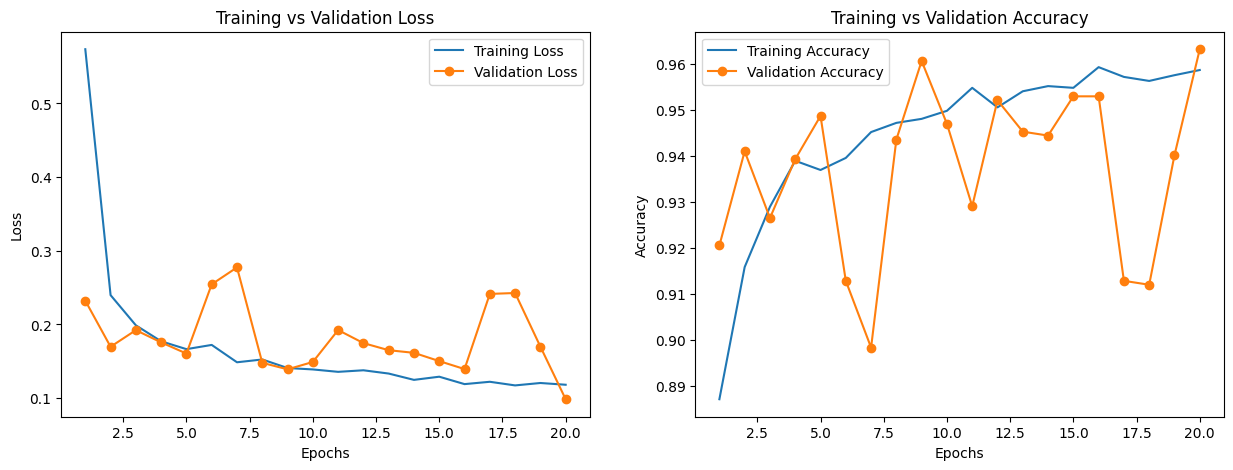

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
epoch_runs = [i+1 for i in range(20)]
ax1.plot(epoch_runs, train_loss, label='Training Loss')
ax1.plot(epoch_runs, val_loss, label='Validation Loss', marker='o')
ax1.set(title='Training vs Validation Loss', xlabel='Epochs',ylabel='Loss')
ax1.legend()
ax2.plot(epoch_runs, train_acc, label='Training Accuracy')
ax2.plot(epoch_runs, val_acc, label='Validation Accuracy', marker='o')
ax2.set(title='Training vs Validation Accuracy', xlabel='Epochs',ylabel='Accuracy')
ax2.legend()
plt.show()

# 8. Evaluation

In [18]:
model.save("pneumonia_detection.keras")
saved_model = tf.keras.models.load_model("pneumonia_detection.keras")
test_dir = 'pneumonia_data/test'
# Assuming you have a separate test dataset stored in the variable test_dir
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=32, class_mode='categorical', target_size=(224,224))

# Evaluate the model on the test dataset
test_loss, test_acc = saved_model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

Found 40 images belonging to 3 classes.
2/2 [==============================] - 10s 4s/step - loss: 0.1118 - acc: 0.9500
Test Loss: 0.11182089149951935
Test Accuracy: 0.949999988079071
